# Investigation of Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest (Fandango is an online movie ratings aggregator). He published his analysis in this article — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:
<ul>
<li>The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
<li>In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
<li>For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.
</ul>

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Understanding the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
fandango_score_comparison = pd.read_csv("fandango_score_comparison.csv")
movie_ratings = pd.read_csv("movie_ratings_16_17.csv")

In [3]:
fandango_score_comparison.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [4]:
movie_ratings.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


From the data from the two dataframes, we have to select the columns which are required for the analysis of the Fandango ratings. So, the columns that are suitable for our analysis are as follows - 
<ol>
<li>fandango_score_comparison - 'FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference'
<li>movie_ratings - 'movie', 'year', 'fandango'
</ol>

This will provide us with data of Fandango before and after Hickey's analysis.

In [15]:
# Selecting the related columns
fandango_before = fandango_score_comparison[['FILM','Fandango_Stars','Fandango_Ratingvalue','Fandango_votes','Fandango_Difference']].copy()

fandango_after = movie_ratings[["movie", "year", "fandango"]].copy()

In [23]:
# Compute the year of the films in fandango_before
fandango_before['year'] = fandango_before['FILM'].str[-5:-1]
fandango_before['year'].value_counts()

2015    129
2014     17
Name: year, dtype: int64

In [24]:
fandango_after["year"].value_counts()

2016    191
2017     23
Name: year, dtype: int64

Our population of interest is in the year 2015 of the fandango_previous dataset which has the Hickey's data and the fandango's 2016 data which is post Hickey's analysis.

In [26]:
# Obtaining the 2015 and 2016 data
fandango_2015 = fandango_before[fandango_before['FILM'].str[-5:-1] == '2015'].copy()
fandango_2016 = fandango_after[fandango_after["year"] == 2016].copy()
fandango_2015.head()


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015,2015


In [28]:
# Sampling the dataset
fandango_201510 = fandango_2015["FILM"].sample(n=10, random_state = 1)
fandango_201610 = fandango_2016["movie"].sample(n=10, random_state = 1)
print(fandango_201510)
print(fandango_201610)

138                  Spare Parts (2015)
120                 The Wolfpack (2015)
63                      Child 44 (2015)
64                   Dark Places (2015)
40     I'll See You In My Dreams (2015)
135           The Lazarus Effect (2015)
139                       Serena (2015)
42                    About Elly (2015)
38                 Saint Laurent (2015)
59                     Mortdecai (2015)
Name: FILM, dtype: object
36                             Collide
75           Ice Age: Collision Course
125                   Now You See Me 2
171           The Disappointments Room
92            Kubo and the Two Strings
134    Pride and Prejudice and Zombies
40                            Deadpool
115                      Money Monster
204                           War Dogs
111               Miracles from Heaven
Name: movie, dtype: object


Here, we have used stratified random sampling where the data is grouped based on the year and random sampling is done. The data to be included in the sample sorely depends on the random_state variable value that is assigned. Each movie is equally likely to be included in the sample based on the random state.

## Comparing distribution shapes of 2015 and 2016 movies

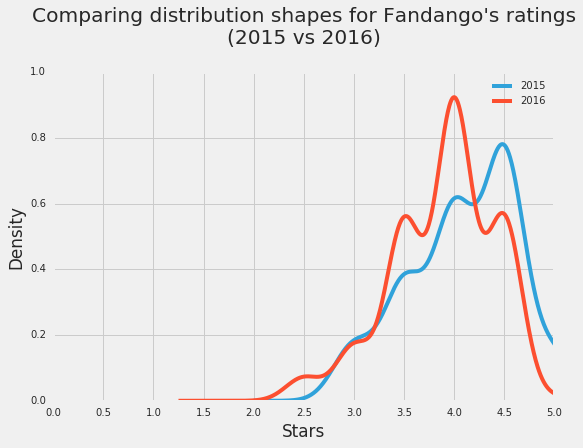

In [30]:
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015',legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)", y = 1.07) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings starts from 0 and ends at 5
plt.xticks(np.arange(0,5.1,0.5))
plt.show()

Two aspects are striking on the figure above:
<ul>
<li>Both distributions are strongly left skewed.
<li>The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.
</ul>
The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

## Comparing Relative frequencies

In [31]:
# 2015 ratings relative frequencies
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [32]:
# 2016 ratings relative frequencies
fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

From the relative frequencies data, we can infer that the ratings 4.5 and 5 has lower relative frequencies in 2016 compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

## Computing directionality of change

In [33]:
# Computing mean, median and mode of each distribution
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

# Creating a new dataframe for the summary statistics on a comparative levl.
summary = pd.DataFrame()
summary['2015'] = [mean_2015,median_2015,mode_2015]
summary['2016'] = [mean_2016,median_2016,mode_2016]
summary.index = ['mean','median','mode']
print(summary)


            2015      2016
mean    4.085271  3.887435
median  4.000000  4.000000
mode    4.500000  4.000000


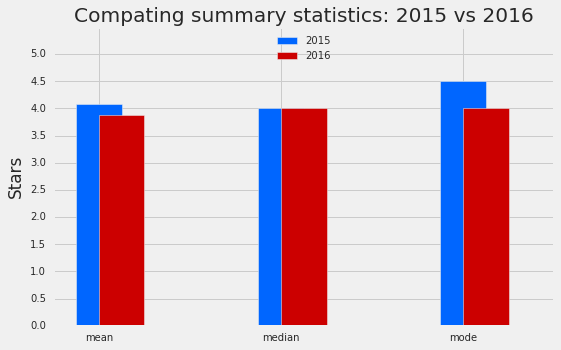

In [36]:
# Comparing the differences in the metrics via graphs
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align='center', label = '2015',width = .25)
summary['2016'].plot.bar(color = '#CC0000',align = 'edge', label = '2016',width = .25, rot = 0, figsize = (8,5))

plt.title("Compating summary statistics: 2015 vs 2016")
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

## Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.